## GPS Trajectory Map-matching Demo

由于网上的公开轨迹数据集往往是GPS数据集，而有时项目中需要使用路网映射后的数据。因此本文档描述了一种基于HMM模型的，对GPS轨迹进行路网映射算法的python实现demo，并提供了可视化工具。<br/>
所依赖的第三方库主要包括:<br/>
transbigdata          --轨迹预处理和可视化<br/>
leuvenmapmatching     --地图匹配算法包<br/>
geopandas             --处理空间数据的库，操作方式类似pandas<br/>

## 加载数据集

In [1]:
# 空间数据预处理包
import transbigdata as tbd
import pandas as pd
# 地图匹配包
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap
# from leuvenmapmatching import visualization as mmviz
import geopandas
import sys
sys.path.append('..')
from utils.utils import *
# 忽略普通告警
import warnings
warnings.filterwarnings("ignore")
import osmnx as ox
from tqdm import tqdm
import numpy as np
from tqdm import trange
import osmnx as ox
import geopandas as gpd
import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

# FOR FILE
import zipfile

# DATA PREPROCESSING
import pandas as pd
import datetime 
import numpy as np
import re

# VISUALIZATION
import folium
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# MACHINE LEARNING PACKAGES
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
dataset_dir = "C:/tyb_file/tyb_tasks/pathlet/datasets/"


In [2]:
## Unzipfile
zip_file_sample = zipfile.ZipFile(dataset_dir+"sampleSubmission.csv.zip")
zip_file_train = zipfile.ZipFile(dataset_dir+"train.csv.zip")
zip_file_test = zipfile.ZipFile(dataset_dir+"test.csv.zip")
zip_file_GPSlocation = zipfile.ZipFile(dataset_dir+"metaData_taxistandsID_name_GPSlocation.csv.zip")

# Converting Files To Pandas Dataframe
sample = pd.read_csv(zip_file_sample.open('sampleSubmission.csv'))
train = pd.read_csv(zip_file_train.open("train.csv"))
test = pd.read_csv(zip_file_test.open("test.csv"))
location = pd.read_csv(zip_file_GPSlocation.open("metaData_taxistandsID_name_GPSlocation.csv"))

In [3]:
lat_list=[]
lng_list=[]
TRIP_ID_list = []
timestamp_list = [] 
for tra_index in trange(len(train)//4):
    if not train.iloc[tra_index]["MISSING_DATA"]:
        if train.iloc[tra_index]["POLYLINE"] !='[]':
            k = re.sub(r"[[|[|]|]|]]", "", train.iloc[tra_index]["POLYLINE"]).split(",")
        
            start_timestamp = train.iloc[tra_index]["TIMESTAMP"]
            TRIP_ID = train.iloc[tra_index]["TRIP_ID"]

            for i in range(len(k)):
                if i %2==0:
                    lat_list.append(float(k[i]))
                else:
                    lng_list.append(float(k[i]))
                    timestamp_list.append(start_timestamp+i*15)
                    TRIP_ID_list.append(TRIP_ID)

100%|██████████| 427667/427667 [02:04<00:00, 3446.45it/s]


In [4]:
porto_data = {
    "ID":TRIP_ID_list,
    "Lng":lat_list,
    "Lat":lng_list,
    "Time":timestamp_list
}
porto_df = pd.DataFrame(porto_data)
porto_df.head(2)

ID       Lng        Lat        Time
0  1372636858620000589 -8.618643  41.141412  1372636873
1  1372636858620000589 -8.618499  41.141376  1372636903

tbd可视化总体data 以及某一个trip随时间动向

In [5]:
# tbd.visualization_trip(data,col = ['Lng', 'Lat', 'VehicleNum', 'Time'])
# tbd.visualization_data(porto_df,col = ['Lng','Lat'],accuracy=300)

In [6]:
# bounds_porto = [-8.63,41.14,-8.58,41.164]
bounds_porto = [-8.65,41.13,-8.56,41.17]
# bounds_porto = [-8.65,41.12,-8.57,41.174]#middle
bounds_porto = [-8.71,41.09,-8.55,41.22]#_big  13.5km宽  15.3km高  每一个grid 为6.75km宽*5.1km高
width=bounds_porto[2]-bounds_porto[0]
height=bounds_porto[3]-bounds_porto[1]
union_bounds = bounds_porto
bounds = bounds_porto

## 使用矩阵分割深圳市 获得每一个grid的轨迹

In [7]:
# 与之前的方式不同 这次的过滤思路是先使用空间过滤 然后再分组过滤掉比较少的轨迹 这样的话就相当于留下了在这个区域内停留过一定时间的轨迹
def generate_subset_using_bound_porto(raw_data,bound):
    res_subset = raw_data[raw_data["Lng"]>bound[0]]
    res_subset = res_subset[res_subset["Lng"]<bound[2]]
    res_subset = res_subset[res_subset["Lat"]>bound[1]]
    res_subset = res_subset[res_subset["Lat"]<bound[3]]
    group_counts = res_subset.groupby('ID').size()
    filtered_groups = group_counts[group_counts > 10]
    result = res_subset[res_subset['ID'].isin(filtered_groups.index)]
    return result

from tqdm import trange
# 输出为一个二维list 每一项包括 bounds 轨迹数量 轨迹id list
res_list = []#二维list 每一个元素存储bound、tra数量以及trd_id_list
cnt_list =[]


divide_num1=2
divide_num2=3
for i in trange(0,divide_num1):
    res_list.append([])
    cnt_list.append([])
    for j in range(0,divide_num2):
        res_list[i].append([])
        temp_bounds=[float(1/divide_num1)*i*width+bounds[0],float(1/divide_num2)*j*height+bounds[1],\
            float(1/divide_num1)*(i+1)*width+bounds[0],float(1/divide_num2)*(j+1)*height+bounds[1]]
        porto_df_subset = generate_subset_using_bound_porto(porto_df,temp_bounds)

        # print(i,j,len(oddata_subset))
        res_list[i][j].append(temp_bounds)
        res_list[i][j].append(len(porto_df_subset))
        cnt_list[i].append(len(porto_df_subset))
        # res_list[i][j].append(oddata_subset)
        tra_id_list = list(set(porto_df_subset['ID']))
        res_list[i][j].append(tra_id_list)
        # data_deliver_sonset = data_deliver[data_deliver['ID'].isin(tra_id_list)]
        # res_list[i][j].append(data_deliver_sonset)
# 画出这些网格的轨迹的数量的分布情况
# res_df = pd.DataFrame(res,columns=["count"])
# res_df.hist("count",bins=20)

# 打印每一个grid的轨迹数量
pd.DataFrame(cnt_list)#.values).max()

100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


0         1        2
0   90889   4258546   848115
1  407206  11507771  1204206

### 加载某一个grid的路网

In [8]:
padding = [0.002,0.002]#经纬度分别的paddiing

union_list_of_bounds = []
m,n=1,1
for i in range(m,m+1):
    for j in range(n,n+1):
        union_list_of_bounds.append(res_list[i][j][0])
union_bounds = union_multi_grids(union_list_of_bounds)
temp_bounds = union_bounds
print(temp_bounds)

[-8.63, 41.13333333333333, -8.55, 41.17666666666667]


In [9]:
def load_map(temp_bounds,padding):
    north, south, east, west = temp_bounds[3]+padding[1], temp_bounds[1]-padding[1], temp_bounds[2]+padding[0], temp_bounds[0]-padding[0]
    G = ox.graph_from_bbox(north, south, east, west)
    #获取道路中心点坐标
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
    edges['lon'] = edges.centroid.x
    edges['lat'] = edges.centroid.y
    #转换路网的坐标系
    G_p = ox.project_graph(G, to_crs=2416)
    nodes_p, edges_p = ox.graph_to_gdfs(G_p, nodes=True, edges=True)
    return G,G_p,nodes,nodes_p,edges,edges_p

connect done


<Figure size 1500x500 with 0 Axes>

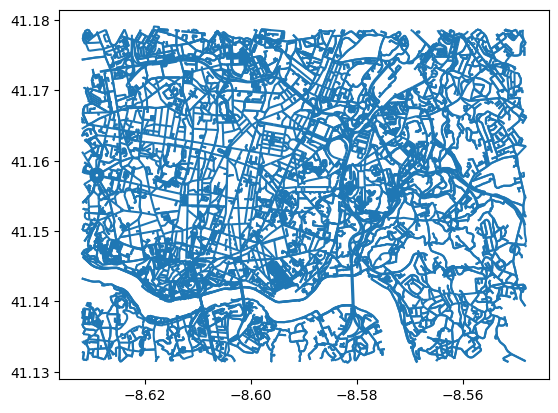

In [10]:

padding = [0.002,0.002]#经纬度分别的paddiing
G,G_p,nodes,nodes_p,edges,edges_p =load_map(temp_bounds,padding)
print("connect done")
plt.figure(figsize=(15, 5))
edges.plot()

# 将路网转换为网络
map_con = InMemMap(name='pNEUMA', use_latlon=False) # , use_rtree=True, index_edges=True)
# 构建网络
for node_id, row in nodes_p.iterrows():
    map_con.add_node(node_id, (row['y'], row['x']))
for node_id_1, node_id_2, _ in G_p.edges:
    map_con.add_edge(node_id_1, node_id_2)

### 进行路网映射 结果输出为tra_dataset

In [11]:
# 遍历轨迹数据集
tra_dataset = []
tra_id_list_for_save = []
tra_match_res=[]
tra_time_list = []
tra_start_time_list = []
cnt=0
# for i in reversed(tra_id):
tra_index = 1
# single region
tra_id_list = list(set(porto_df["ID"].tolist()))

        
print(len(tra_id_list))

426160


In [12]:
def str2timestamp(target_str):
    import time
    timeArray = time.strptime("2019-5-10 "+target_str, "%Y-%m-%d %H:%M:%S")
    # print(timeArray)
    timeStamp = time.mktime(timeArray)
    return timeStamp


tra_ids = tra_id_list[:15000]
# tra_ids = tra_id_list[15000:45000]
# print("len(tra_id):",len(tra_id))
for i in  tqdm(tra_ids):
    cnt+=1
    # 使用一个矩形框 选中一个轨迹在矩形内的点
    tmp_gdf = porto_df[porto_df['ID'] == i].sort_values(by = 'Time')
    
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]>union_bounds[0]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]<union_bounds[2]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]>union_bounds[1]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]<union_bounds[3]]
    
    if len(tmp_gdf)>20:#被选中的部分至少有5个gps数据点

        #轨迹增密
        # tmp_gdf = tbd.traj_densify(tmp_gdf,col = ['ID', 'Time', 'Lng', 'Lat'],timegap = 60)

        #转换轨迹的坐标系为地理坐标系
        tmp_gdf['geometry'] = gpd.points_from_xy(tmp_gdf['Lng'],tmp_gdf['Lat'])
        tmp_gdf = gpd.GeoDataFrame(tmp_gdf)
        tmp_gdf.crs = {'init':'epsg:4326'}
        tmp_gdf = tmp_gdf.to_crs(2416)
        # tmp_gdf.plot()
        #获得轨迹点
        path = list(zip(tmp_gdf.geometry.y, tmp_gdf.geometry.x))
        #构建地图匹配工具
        matcher = DistanceMatcher(map_con, 
                                max_dist=500, 
                                max_dist_init=170, 
                                min_prob_norm=0.0001,
                                non_emitting_length_factor=0.95,
                                obs_noise=50, 
                                obs_noise_ne=50,
                                    dist_noise=50,
                                    max_lattice_width=20,
                                    non_emitting_states=True)
        #进行地图匹配
        states, _ = matcher.match(path, unique=False)
        if len(states)>10:# 过滤 至少要经过6条边
            tmp_tra = []
            for edge in states:
                if edge not in tmp_tra:
                    tmp_tra.append(edge)
                
            tra_dataset.append(tmp_tra) 
            tra_id_list_for_save.append(i)
            # tra_match_res.append(matcher.lattice_best)

            tra_time_list.append((tmp_gdf.iloc[-1]["Time"])-(tmp_gdf.iloc[0]["Time"]))
            tra_start_time_list.append(tmp_gdf.iloc[0]["Time"])

  0%|          | 42/30000 [00:45<9:27:16,  1.14s/it]Searching closeby nodes with linear search, use an index and set max_dist
Searching closeby nodes with linear search, use an index and set max_dist
  0%|          | 150/30000 [03:05<10:59:34,  1.33s/it]Searching closeby nodes with linear search, use an index and set max_dist
Searching closeby nodes with linear search, use an index and set max_dist
  1%|          | 208/30000 [04:04<5:37:48,  1.47it/s]Searching closeby nodes with linear search, use an index and set max_dist
Searching closeby nodes with linear search, use an index and set max_dist
  1%|          | 321/30000 [06:15<13:30:55,  1.64s/it]Searching closeby nodes with linear search, use an index and set max_dist
Searching closeby nodes with linear search, use an index and set max_dist
  1%|          | 371/30000 [07:03<7:30:41,  1.10it/s]Searching closeby nodes with linear search, use an index and set max_dist
Searching closeby nodes with linear search, use an index and set max

In [14]:
tra_dataset_final = []
tra_id_list_final = []
tra_time_list_final = []
tra_start_time_list_final = []
for i in trange(len(tra_id_list_for_save)):
    if len(tra_dataset[i])>5:
        tra_dataset_final.append(tra_dataset[i])
        tra_id_list_final.append(tra_id_list_for_save[i])
        tra_time_list_final.append(tra_time_list[i])
        tra_start_time_list_final.append(tra_start_time_list[i])
tra_dataset = tra_dataset_final
tra_id_list_for_save = tra_id_list_final
tra_time_list = tra_time_list_final
tra_start_time_list = tra_start_time_list_final
import numpy as np
distinct_name ="porto"
# np.save(dataset_dir+'/tra_dataset_haidian'+str(m)+'_'+str(n)+'_'+str(len(tra_dataset))+'.npy',np.array(tra_dataset,dtype=object))   # 保存为.npy格式 
np.save(dataset_dir+'/tra_dataset'+distinct_name+'_'+str(len(tra_dataset))+'.npy',np.array(tra_dataset,dtype=object))   # 保存为.npy格式 
np.save(dataset_dir+'/tra_id_list'+distinct_name+str(len(tra_dataset))+'.npy',np.array(tra_id_list_for_save,dtype=object))   # 保存为.npy格式 

c=np.load(dataset_dir+'/tra_id_list'+distinct_name+str(len(tra_dataset))+'.npy',allow_pickle=True)
tra_id_list_load=c.tolist()
print("number of tras for matrix method:",len(tra_dataset))
print("number of tras for matrix method:",len(tra_id_list_load))

np.save(dataset_dir+'/tra_time_list'+distinct_name+str(len(tra_dataset))+'.npy',np.array(tra_time_list,dtype=object))   # 保存为.npy格式
# np.save(dataset_dir+'/tra_match_res'+distinct_name+str(len(tra_dataset))+'.npy',np.array(tra_match_res,dtype=object))   # 保存为.npy格式

np.save(dataset_dir+'/tra_start_time_list'+distinct_name+str(len(tra_dataset))+'.npy',np.array(tra_start_time_list,dtype=object))   # 保存为.npy格式 

    

100%|██████████| 17741/17741 [00:00<00:00, 342397.28it/s]


number of tras for matrix method: 17741
number of tras for matrix method: 17741


In [ ]:
# from leuvenmapmatching import visualization as mmviz
# mmviz.plot_map(map_con, matcher=matcher,
#                show_labels=False, show_matching=True, show_graph=True,
#                filename="my_plot.png")

我们这里把整个porto的轨迹都做好路网映射了，之后只需要从中框选自己所需要的即可

In [11]:
# tra_id_list=np.load(dataset_dir+'new_dataset/porto/tra_id_listporto12960.npy',allow_pickle=True).tolist()
# tra_dataset=np.load(dataset_dir+'new_dataset/porto/tra_datasetporto_12960.npy',allow_pickle=True).tolist()
tra_id_list=np.load(dataset_dir+'new_dataset/porto/tra_id_listporto1_1_10476shrink.npy',allow_pickle=True).tolist()
tra_dataset=np.load(dataset_dir+'new_dataset/porto/tra_datasetporto1_1_10476shrink.npy',allow_pickle=True).tolist()



In [12]:
# source_path = tra_dataset[1]#获取整个futian数据集中的某一条具体轨迹
# pathdf = pd.DataFrame(source_path,columns = ['u','v'])
# pathgdf = pd.merge(pathdf,edges.reset_index())
# pathgdf = gpd.GeoDataFrame(pathgdf)
# pathgdf.plot()
# # pathgdf.crs = {'init':'epsg:2416'}
# # pathgdf_4326_ = pathgdf.to_crs(4326)

In [13]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
padding = [0.002,0.002]

distinct_name="porto"
part_tra_dataset=[]
part_ids=[]


for i in trange(len(tra_dataset)):
    source_path = tra_dataset[i]#获取整个futian数据集中的某一条具体轨迹
    pathdf = pd.DataFrame(source_path,columns = ['u','v'])
    pathgdf = pd.merge(pathdf,edges.reset_index())
    pathgdf = gpd.GeoDataFrame(pathgdf)
    # 进行框选
    selected = pathgdf
    if len(selected)>20:
        part_tra = [] 
        temp_u = list(selected['u'])
        temp_v = list(selected['v'])

        for j in range(len(selected)):
            part_tra.append((temp_u[j],temp_v[j]))

        part_tra_dataset.append(part_tra)
        part_ids.append(tra_id_list[i])


np.save(dataset_dir+'/tra_dataset'+distinct_name+str(len(part_tra_dataset))+'shrink.npy',np.array(part_tra_dataset,dtype=object))   # 保存为.npy格式 
np.save(dataset_dir+'/tra_id_list'+distinct_name+str(len(part_tra_dataset))+'shrink.npy',np.array(part_ids,dtype=object))   # 保存为.npy格式 


100%|██████████| 12960/12960 [11:23<00:00, 18.96it/s]


In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
padding = [0.002,0.002]

distinct_name="porto"

for iter_i in range(0,2):
    for iter_j in range(0,3):
        print(iter_i,iter_j,res_list[iter_i][iter_j][0])
        union_bounds = res_list[iter_i][iter_j][0]
        part_ids = []
        part_tra_dataset = []
        G,G_p,nodes,nodes_p,edges,edges_p =load_map(union_bounds,padding)
        print("connect done")
        plt.figure(figsize=(15, 5))
        edges.plot()

        # 将路网转换为网络
        map_con = InMemMap(name='pNEUMA', use_latlon=False) # , use_rtree=True, index_edges=True)
        # 构建网络
        for node_id, row in nodes_p.iterrows():
            map_con.add_node(node_id, (row['y'], row['x']))
        for node_id_1, node_id_2, _ in G_p.edges:
            map_con.add_edge(node_id_1, node_id_2)
        for i in trange(len(tra_dataset)):
            source_path = tra_dataset[i]#获取整个futian数据集中的某一条具体轨迹
            pathdf = pd.DataFrame(source_path,columns = ['u','v'])
            pathgdf = pd.merge(pathdf,edges.reset_index())
            pathgdf = gpd.GeoDataFrame(pathgdf)
            # 进行框选
            selected = pathgdf
            if len(selected)>20:
                part_tra = [] 
                temp_u = list(selected['u'])
                temp_v = list(selected['v'])

                for j in range(len(selected)):
                    part_tra.append((temp_u[j],temp_v[j]))

                part_tra_dataset.append(part_tra)
                part_ids.append(tra_id_list[i])
                # tra_time_list.append(str2timestamp(selected.iloc[-1]["Time"])-str2timestamp(selected.iloc[0]["Time"]))
                # tra_start_time_list.append(int(selected.iloc[0]["Time"][:2])*60+int(selected.iloc[0]["Time"][3:5]))

                # selected.plot()
        print(iter_i,iter_j,len(part_ids))
        np.save(dataset_dir+'/tra_dataset'+distinct_name+str(iter_i)+'_'+str(iter_j)+'_'+str(len(part_tra_dataset))+'shrink.npy',np.array(part_tra_dataset,dtype=object))   # 保存为.npy格式 
        np.save(dataset_dir+'/tra_id_list'+distinct_name+str(iter_i)+'_'+str(iter_j)+'_'+str(len(part_tra_dataset))+'shrink.npy',np.array(part_ids,dtype=object))   # 保存为.npy格式 
        # np.save(dataset_dir+'/generated_from_futian/tra_start_time_list'+distinct_name+str(iter_i)+'_'+str(iter_j)+'_'+str(len(part_tra_dataset))+'.npy',np.array(tra_start_time_list,dtype=object))   # 保存为.npy格式 
        # np.save(dataset_dir+'/generated_from_futian/tra_time_list'+distinct_name+str(iter_i)+'_'+str(iter_j)+'_'+str(len(part_tra_dataset))+'.npy',np.array(tra_time_list,dtype=object))   # 保存为.npy格式


In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(15,12))
tbd.clean_outofbounds(edges,bounds_porto,col = ['lon','lat']).plot(ax = axes,color = '#333',lw = 0.1)
axes.axhline(y=bounds_porto[1]+(bounds_porto[3]-bounds_porto[1])/3, color='orange', linestyle='-',linewidth=4)
axes.axhline(y=bounds_porto[1]+(bounds_porto[3]-bounds_porto[1])*2/3, color='orange', linestyle='-',linewidth=4)
axes.axhline(y=bounds_porto[1], color='orange', linestyle='-',linewidth=4)
axes.axhline(y=bounds_porto[3], color='orange', linestyle='-',linewidth=4)
# 绘制竖直线
axes.axvline(x=(bounds_porto[0]+bounds_porto[2])/2, color='orange', linestyle='-',linewidth=4)
axes.axvline(x=(bounds_porto[0]+bounds_porto[0])/2, color='orange', linestyle='-',linewidth=4)
axes.axvline(x=(bounds_porto[2]+bounds_porto[2])/2, color='orange', linestyle='-',linewidth=4)
plt.show()

# 可视化阶段 把路径在地图上画出来

In [13]:
# 参数配置
color_list = ['blue','red','darkgreen','purple',"peru","darkorange"]

# 绘制一条path或一条tra
# path代表需要绘制的路径，格式为edge构成的list
# edges和edges_p 代表底图路网，bounds代表观察窗口
def plot_tra(path,edges,edges_p,bounds,color='blue',ax = None,plt_show=None):
    if ax==None:
        fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(14,10))
        tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = axes,color = '#333',lw = 0.1)
    else:
        axes=ax
    
    for j in range(len(path)):
        plot_edge(edges_p,path[j]).plot(ax = axes,zorder = 1,color = color,alpha = 0.8)
    if plt_show:
        plt.show()
    return axes
# plot_tra(tra_edge_list_load[loc2],edges,edges_p,bounds,color='blue',ax = None,plt_show=None)

# 输入r矩阵和哪一列，输出用到的path的list  (从path_list中把使用到的挑出来 是无序的)
def get_path_list_usedtorec(r_tensor,col_index,path_list):
    temp_path_list = []#记录表达该轨迹所用到的path
    R_col = r_tensor[:,col_index]
    for i in range(len(R_col)):
        if R_col[i]==1:
            temp_path_list.append(path_list[i])
    return temp_path_list


In [16]:
# 加载保存好的地图匹配的结果继续可视化 这里有点关注p of p 问题 所以在代码设计中考虑了同时考虑了兼容两个网格和合并网格的结果
# 查看没有使用pathlet抽取算法之前，原始的分割数据是什么样子的，发现中间有断开的情况，可能会影响后续计算
import pandas as pd
all_tra_id_list_load = []
all_tra_edge_list_load = []

tra_id_list_load=np.load(dataset_dir+'new_dataset/porto/tra_id_listporto1_1_10476shrink.npy',allow_pickle=True).tolist()
tra_edge_list_load=np.load(dataset_dir+'new_dataset/porto/tra_datasetporto1_1_10476shrink.npy',allow_pickle=True).tolist()

# tra_id_list_load=np.load(dataset_dir+'new_dataset/porto/tra_id_listporto12960.npy',allow_pickle=True).tolist()
# tra_edge_list_load=np.load(dataset_dir+'new_dataset/porto/tra_datasetporto_12960.npy',allow_pickle=True).tolist()

all_tra_id_list_load.append(tra_id_list_load)
all_tra_edge_list_load.append(tra_edge_list_load)


In [14]:
import json
with open('C:/tyb_file/tyb_tasks/pathlet/datasets/from_server/class_res_porto_1_1.json', 'r') as file:
    loaded_list = json.load(file)
# loaded_list

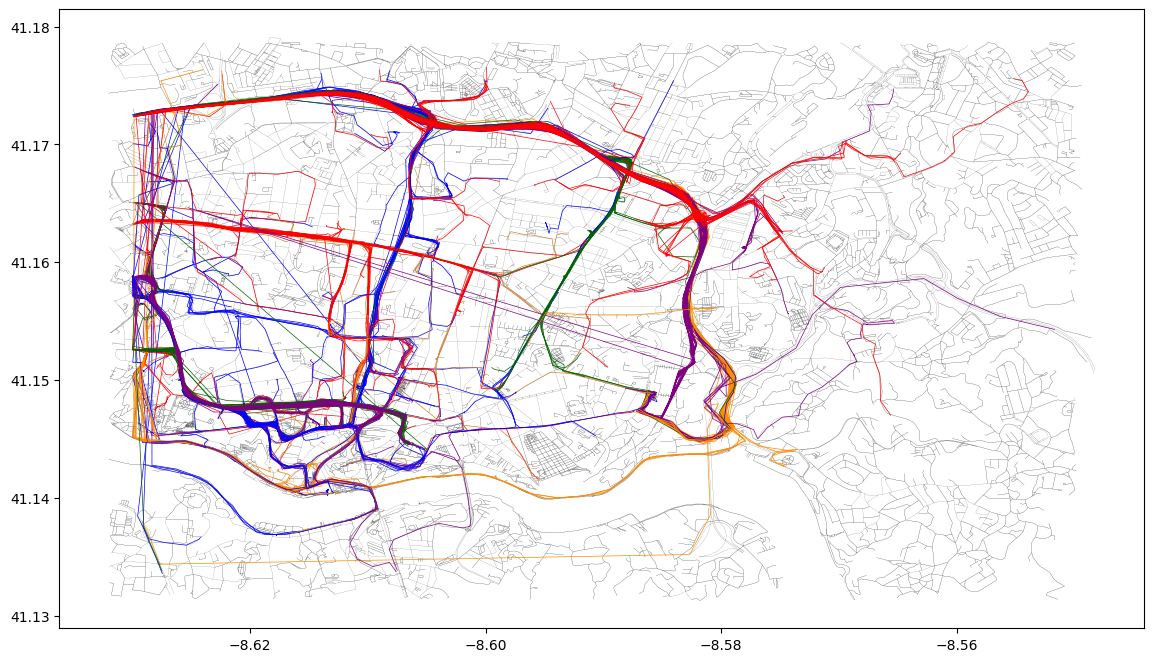

In [24]:
# 这个cell只是用来绘制一个grid里边的所有轨迹
# 可以用来绘制不同的类别的轨迹 深圳的有点乱不知道是不是因为轨迹质量问题
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,10))
ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)

for i in range(len(loaded_list)):
    # if i not in [5, 7 ,14, 16 ,18 ,20, 23 ,27, 28]:
    if i >15:
        continue
    # fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    # ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)
    class1 =loaded_list[i]

    ids_common = np.load("C:/tyb_file/tyb_tasks/pathlet/datasets/from_server/ids_common_porto.npy",allow_pickle=True).tolist()

    for tra_index in class1[:40]:
        id =  ids_common[tra_index]
        loc = all_tra_id_list_load[0].index(id)
        path = all_tra_edge_list_load[0][loc]
        # for j in range(len(path)):
        #     try:
        #         plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,color = color_list[tra_index%len(color_list)],alpha = 0.2)
        #     except:
        #         m=0


        tmp_gdf = porto_df[porto_df['ID'] == id].sort_values(by = 'Time')
            # print(len(tmp_gdf))
            # 轨迹增密
            # tmp_gdf = tbd.traj_densify(tmp_gdf,col = ['ID', 'Time', 'Lng', 'Lat'],timegap = 15)
            # 转换轨迹的坐标系为地理坐标系
        tmp_gdf['geometry'] = gpd.points_from_xy(tmp_gdf['Lng'],tmp_gdf['Lat'])
        tmp_gdf = gpd.GeoDataFrame(tmp_gdf)
        tmp_gdf = tmp_gdf[tmp_gdf["Lng"]>union_bounds[0]]
        tmp_gdf = tmp_gdf[tmp_gdf["Lng"]<union_bounds[2]]
        tmp_gdf = tmp_gdf[tmp_gdf["Lat"]>union_bounds[1]]
        tmp_gdf = tmp_gdf[tmp_gdf["Lat"]<union_bounds[3]]
        # tmp_gdf.plot(ax=ax,color="red",alpha = 0.3)
        import geopandas as gpd
        from shapely.geometry import Point, LineString
        points = tmp_gdf.geometry.reset_index(drop=True)
        line = LineString(points)
        line
        gdf = gpd.GeoDataFrame(geometry=[line])
        # fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
        # ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)
        gdf.plot(ax=ax,alpha = 1,linewidth=.5,color = color_list[i%len(color_list)])
plt.show()

        # tmp_gdf.crs = {'init':'epsg:4326'}
        # tmp_gdf = tmp_gdf.to_crs(2416)

        # selected = tmp_gdf[tmp_gdf.geometry.intersects(bbox)]
        # selected.plot(ax=ax,color="red",alpha = 0.3)

        

    # for tra_index in range(1800):
    #     if all_tra_id_list_load[0][tra_index] in all_tra_id_list_load[1] and all_tra_id_list_load[0][tra_index] in all_tra_id_list_load[2]:
    #         path = all_tra_edge_list_load[0][tra_index]
    #         for j in range(len(path)):
    #             try:
    #                 plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,color = color_list[tra_index%len(color_list)],alpha = 0.8)
    #             except:
    #                 m=0



先画一下轨迹映射后的结果（也就是最原始的gps序列和轨迹）

In [25]:
47163+67836+3781

118780

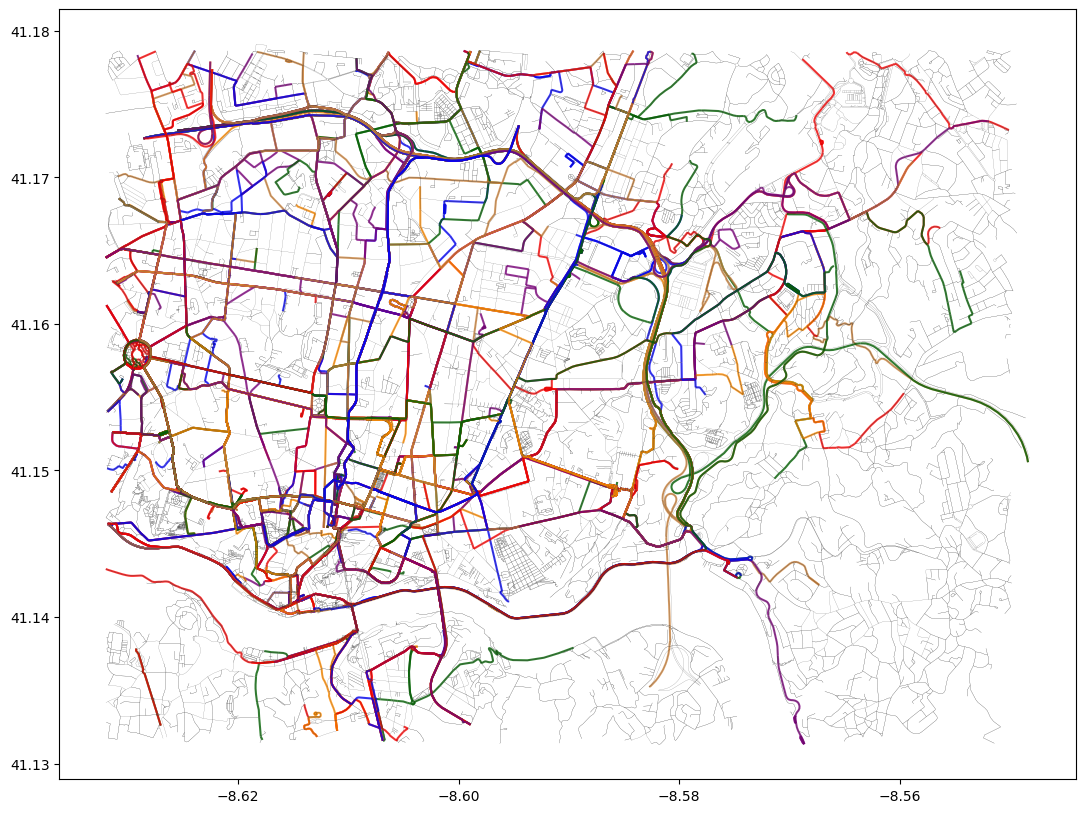

In [20]:
data_deliver = porto_df
tra_index = 1
ax = plot_tra(tra_dataset[tra_index],edges,edges_p,bounds_porto,color=color_list[tra_index%6],ax = None,plt_show=None)
for tra_index in range(2,3):
# tra_index = 10
    ax = plot_tra(tra_dataset[tra_index],edges,edges_p,bounds_porto,color=color_list[tra_index%6],ax = ax,plt_show=None)

# tmp_gdf = data_deliver[data_deliver['ID'] == tra_id_list[tra_index]].sort_values(by = 'Time')

#轨迹增密
# tmp_gdf = tbd.traj_densify(tmp_gdf,col = ['ID', 'Time', 'Lng', 'Lat'],timegap = 15)
#转换轨迹的坐标系为地理坐标系
# tmp_gdf['geometry'] = gpd.points_from_xy(tmp_gdf['Lng'],tmp_gdf['Lat'])
# tmp_gdf = gpd.GeoDataFrame(tmp_gdf)
# tmp_gdf = tmp_gdf[tmp_gdf["Lng"]>union_bounds[0]]
# tmp_gdf = tmp_gdf[tmp_gdf["Lng"]<union_bounds[2]]
# tmp_gdf = tmp_gdf[tmp_gdf["Lat"]>union_bounds[1]]
# tmp_gdf = tmp_gdf[tmp_gdf["Lat"]<union_bounds[3]]
# # tmp_gdf.crs = {'init':'epsg:4326'}
# # tmp_gdf = tmp_gdf.to_crs(2416)

# # selected = tmp_gdf[tmp_gdf.geometry.intersects(bbox)]
# # selected.plot(ax=ax,color="red",alpha = 0.3)
# tmp_gdf.plot(ax=ax,color="red",alpha = 0.3)

plt.show()


In [ ]:

tra_index =   98
# tra_index_list =[13, 14, 41, 42, 47, 52, 56, 66, 70, 73, 76, 86, 88, 93, 97, 99, 102, 103, 104, 112, 121, 134, 143, 146, 148, 160, 163, 186, 189, 193, 194, 203, 207, 208, 210, 211, 214, 218, 220, 223, 230, 238, 239, 253, 261, 263, 272, 276, 278, 279, 292, 293, 295, 300, 308, 310, 313, 318, 328, 330, 335, 348, 351, 353, 354, 355, 356, 359, 361, 372, 380, 385, 388, 394, 400, 409, 412, 424, 427, 428, 447, 458, 466, 469, 481, 483, 496, 500, 501, 503, 508, 511, 517, 522, 525, 526, 528, 533, 540, 541, 543, 550, 551, 583, 616, 617, 621, 625, 634, 636, 644, 645, 659, 668, 674, 675, 692, 694, 700, 711, 723, 728, 748, 751, 752, 755, 756, 781, 794, 804, 806, 808, 814, 817, 821, 822, 826, 836, 849, 854, 857, 866, 875, 894, 896, 906, 920, 924, 931, 938, 942, 943, 945, 950, 970, 974, 976, 982, 991, 992, 999, 1005, 1011, 1038, 1039, 1054, 1064, 1083, 1088, 1094, 1104, 1115, 1116, 1119, 1121, 1126, 1150, 1155, 1156, 1162, 1169, 1173, 1174, 1178, 1185, 1196, 1200, 1202, 1207, 1215, 1216, 1218, 1227, 1229, 1235, 1236, 1242, 1244, 1245, 1254, 1258, 1260, 1263, 1269, 1279, 1291, 1298, 1321, 1324, 1350, 1367, 1380, 1381, 1385, 1391, 1397, 1399, 1405, 1425, 1426, 1429, 1448, 1450, 1451, 1458, 1471, 1480, 1484, 1485, 1488, 1489, 1490, 1496, 1497, 1500, 1503, 1504, 1510, 1511, 1526, 1531, 1540, 1541, 1552, 1557, 1560, 1561, 1567, 1569, 1572, 1575, 1579, 1589, 1590, 1591, 1597, 1599, 1601, 1604, 1615, 1617, 1620, 1622, 1630, 1641, 1648, 1652, 1657, 1665, 1670, 1678, 1700, 1708, 1709, 1710, 1711, 1718, 1723, 1742, 1757, 1759, 1760, 1772, 1781, 1783, 1786, 1787, 1790, 1793, 1794, 1797, 1814, 1815, 1821, 1831, 1833, 1835, 1843, 1845, 1848, 1853, 1867, 1869, 1874, 1875, 1878, 1884, 1886, 1888, 1893, 1900, 1901, 1903, 1904, 1911, 1915, 1917, 1927, 1929, 1935, 1937, 1944, 1948, 1949, 1952, 1955, 1968, 1972, 1973, 1976, 1990, 2000, 2006, 2013, 2016, 2017, 2039, 2055, 2056, 2057, 2058, 2062, 2066, 2068, 2073, 2077, 2079, 2081, 2082, 2092, 2093, 2103, 2109, 2113, 2117, 2120, 2124, 2125, 2133, 2142, 2150, 2152, 2153, 2155, 2162, 2163, 2174, 2182, 2211, 2224, 2228, 2259, 2272, 2273, 2274, 2286, 2295, 2297, 2298, 2304, 2321, 2323, 2324, 2326, 2330, 2340, 2343, 2347, 2350, 2358, 2363, 2372, 2379, 2388, 2391, 2395, 2396, 2397, 2399, 2402, 2403, 2404, 2418, 2420, 2434, 2438, 2454, 2471, 2475, 2478, 2484, 2485, 2487, 2495, 2497, 2510, 2526, 2528, 2533, 2539, 2540, 2553, 2555, 2562, 2572, 2586, 2587, 2594, 2600, 2628, 2631, 2632, 2634, 2636, 2637, 2641, 2652, 2677, 2692, 2694, 2698, 2703, 2712, 2718, 2720, 2729, 2740, 2742, 2746, 2747, 2748, 2750, 2755, 2762, 2763, 2772, 2782, 2784, 2789, 2792, 2799, 2820, 2822, 2828, 2839, 2845, 2847, 2849, 2860, 2867, 2868, 2869, 2878, 2891, 2900, 2912, 2925, 2935, 2938, 2942, 2946, 2950, 2965, 2968, 2979, 2981, 2988, 3006, 3009, 3012, 3020, 3022, 3025, 3026, 3036, 3040, 3049, 3051, 3052, 3054, 3057, 3062, 3065, 3069, 3078, 3079, 3082, 3085, 3097, 3103, 3117, 3133, 3140, 3159, 3163, 3187, 3189, 3198, 3205, 3209, 3224, 3226, 3240, 3242, 3243, 3245, 3254, 3260, 3264, 3283, 3284, 3289, 3291, 3296, 3307, 3313, 3317, 3322, 3323, 3333, 3335, 3337, 3341, 3347, 3354, 3356, 3360, 3368, 3371, 3379, 3383, 3394, 3414, 3420, 3426, 3430, 3437, 3438, 3454, 3460, 3463, 3475, 3485, 3486, 3488, 3491, 3499, 3502, 3504, 3535, 3539, 3544, 3546, 3548, 3550, 3551, 3553, 3556, 3557, 3559, 3569, 3575, 3578, 3587, 3591, 3601, 3605, 3617, 3625, 3631, 3639, 3642, 3650, 3654, 3659, 3665, 3683, 3699, 3700, 3703, 3716, 3717, 3718, 3722, 3723, 3730, 3733, 3736, 3742, 3764, 3765, 3774, 3799, 3803, 3805, 3809, 3814, 3822, 3823, 3824, 3830, 3832, 3839, 3842, 3858, 3870, 3882, 3885, 3892, 3893, 3902, 3903, 3911, 3916, 3921, 3922, 3928, 3934, 3937, 3940, 3941, 3948, 3949, 3950, 3955, 3963, 3981, 3982, 3997, 4010, 4013, 4025, 4044, 4050, 4051, 4059, 4061, 4072, 4081, 4103, 4105, 4108, 4135, 4139, 4153, 4154, 4156, 4169, 4181, 4183, 4191, 4192, 4193, 4194, 4216, 4217, 4240, 4249, 4267, 4295, 4297, 4299, 4303, 4306, 4309, 4311, 4313, 4315, 4321, 4329, 4332, 4340, 4362, 4363, 4364, 4366, 4367, 4376, 4380, 4395, 4404, 4405, 4416, 4431, 4438, 4452, 4464, 4468, 4483, 4487, 4493, 4511, 4518, 4519, 4520, 4522, 4532, 4536, 4539, 4546, 4548, 4551, 4566, 4568, 4569, 4570, 4572, 4579, 4582, 4584, 4593, 4597, 4602, 4606, 4608, 4620, 4624, 4626, 4639, 4642, 4647, 4661, 4670, 4678, 4681, 4689, 4696, 4704, 4711, 4727, 4733, 4735, 4736, 4744, 4760, 4765, 4770, 4771, 4775, 4777, 4783, 4784, 4790, 4793, 4794, 4807, 4821, 4822, 4829, 4836, 4838, 4843, 4844, 4860, 4865, 4867, 4868, 4872, 4882, 4885, 4888, 4891, 4895, 4899, 4913, 4925, 4936, 4960, 4967, 4968, 4970, 4973, 4977, 4979, 4981, 4983, 4990, 4996, 4998, 5013, 5014, 5018, 5019, 5033, 5039, 5041, 5042, 5057, 5070, 5074, 5076, 5078, 5080, 5103, 5105, 5111, 5112, 5116, 5120, 5122, 5126, 5129, 5140, 5154, 5159, 5163, 5166, 5167, 5172, 5173, 5177, 5179, 5180, 5182, 5183, 5184, 5193, 5211, 5222, 5224, 5225, 5243, 5245, 5263, 5267, 5291, 5304, 5309, 5326, 5348, 5359, 5363, 5365, 5384, 5388, 5389, 5393, 5395, 5396, 5407, 5415, 5423, 5424, 5430, 5432, 5434, 5436, 5438, 5456, 5459, 5462, 5467, 5468, 5474, 5475, 5476, 5479, 5486, 5492, 5500, 5507, 5511, 5513, 5520, 5527, 5529, 5559, 5560, 5566, 5574, 5577, 5580, 5582, 5584, 5589, 5597, 5603, 5608, 5612, 5616, 5618, 5629, 5631, 5633, 5634, 5652, 5654, 5673, 5677, 5684, 5693, 5702, 5704, 5709, 5710, 5713, 5718, 5732, 5757, 5765, 5769, 5782, 5785, 5786, 5794, 5807, 5815, 5818, 5824, 5825, 5845, 5848, 5857, 5862, 5869, 5871, 5873, 5878, 5879, 5890, 5906, 5912, 5917, 5921, 5944, 5947, 5950, 5958, 5960, 5961, 5962, 5963, 5964, 5965, 5973, 5979, 5991, 5992, 6002, 6003, 6004, 6012, 6015, 6017, 6019, 6023, 6025, 6041, 6061, 6062, 6070, 6071, 6077, 6089, 6092, 6093, 6099, 6104, 6108, 6113, 6114, 6118, 6138, 6141, 6144, 6153, 6155, 6160, 6173, 6189, 6205, 6223, 6224, 6231, 6266, 6273, 6279, 6285, 6290, 6300, 6302, 6307, 6309, 6326, 6329, 6338, 6339, 6341, 6354, 6358, 6363, 6375, 6390, 6401, 6402, 6408, 6410, 6412, 6421, 6426, 6430, 6442, 6452, 6458, 6462, 6468, 6488, 6506, 6528, 6530, 6539, 6544, 6549, 6561, 6566, 6569, 6571, 6578, 6579, 6581, 6583, 6593, 6596, 6598, 6606, 6618, 6634, 6636, 6652, 6666, 6669, 6672, 6675, 6679, 6693, 6704, 6705, 6711, 6721, 6723, 6729, 6732, 6738, 6759, 6760, 6770, 6774, 6783, 6795, 6801, 6802, 6817, 6835, 6838, 6847, 6857, 6874, 6875, 6881, 6896, 6899, 6905, 6906, 6916, 6918, 6935, 6952, 6957, 6959, 6961, 6974, 6977, 6978, 6981, 6984, 6988, 6998, 6999, 7006, 7015, 7016, 7021, 7024, 7026, 7029, 7044, 7049, 7061, 7067, 7079, 7084, 7085, 7087, 7088, 7092, 7093, 7098, 7111, 7112, 7114, 7121, 7128, 7130, 7133, 7136, 7139, 7152, 7153, 7161, 7167, 7170, 7182, 7183, 7189, 7192, 7212, 7218, 7227, 7229, 7236, 7238, 7241, 7244, 7246, 7251, 7259, 7261, 7272, 7282, 7286, 7287, 7289, 7293, 7296, 7307, 7309, 7315, 7317, 7319, 7321, 7331, 7332, 7336, 7337, 7341, 7345, 7350, 7360, 7365, 7369, 7375, 7377, 7382, 7386, 7387, 7390, 7394, 7403, 7415, 7424, 7428, 7431, 7432, 7433, 7437, 7441, 7443, 7452, 7454, 7459, 7466, 7467, 7468, 7470, 7475, 7482, 7484, 7496, 7501, 7504, 7506, 7510, 7517, 7518, 7531, 7534, 7535, 7536, 7538, 7544, 7548, 7549, 7550, 7552, 7554, 7562, 7571, 7574, 7583, 7586, 7591, 7592, 7593, 7599, 7601, 7606, 7608, 7612, 7613, 7615, 7626, 7634, 7653, 7660, 7669, 7674, 7675, 7676, 7681, 7696, 7700, 7713, 7727, 7728, 7733, 7740, 7741, 7746, 7748, 7749, 7759, 7787, 7788, 7793, 7794, 7806, 7810, 7819, 7835, 7839, 7848, 7853, 7862, 7864, 7873, 7876, 7877, 7878, 7885, 7892, 7894, 7909, 7914, 7926, 7935, 7942, 7944, 7946, 7951, 7953, 7957, 7967, 7969, 7974, 7975, 7976, 7994]
tra_id = tra_index_filtered_list[tra_index]#.index(tra_index)
tra_dataset = all_tra_edge_list_load[0]
edges_p['lon'] = edges_p.centroid.x
edges_p['lat'] = edges_p.centroid.y


# for tra_index in tra_index_list[20:25]:
    # print(tra_index)
    # ax = plot_tra(tra_dataset[tra_index],edges,edges_p,bounds,color='blue',ax = None,plt_show=None)
for tra_pair_id in np.load("topk_predictions.npy")[tra_index][5:10]:
# for tra_pair_id in np.load("groundtruth.npy")[tra_id]:
    ax = plot_tra(tra_dataset[tra_index_filtered_list[tra_pair_id]],edges,edges_p,bounds,color='blue',ax = None,plt_show=None)


    tmp_gdf = data_deliver[data_deliver['ID'] == tra_id].sort_values(by = 'Time')
    # print(len(tmp_gdf))
    #轨迹增密
    # tmp_gdf = tbd.traj_densify(tmp_gdf,col = ['ID', 'Time', 'Lng', 'Lat'],timegap = 15)
    #转换轨迹的坐标系为地理坐标系
    tmp_gdf['geometry'] = gpd.points_from_xy(tmp_gdf['Lng'],tmp_gdf['Lat'])
    tmp_gdf = gpd.GeoDataFrame(tmp_gdf)
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]>union_bounds[0]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]<union_bounds[2]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]>union_bounds[1]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]<union_bounds[3]]
    # tmp_gdf.crs = {'init':'epsg:4326'}
    # tmp_gdf = tmp_gdf.to_crs(2416)

    # selected = tmp_gdf[tmp_gdf.geometry.intersects(bbox)]
    # selected.plot(ax=ax,color="red",alpha = 0.3)
    tmp_gdf.plot(ax=ax,color="red",alpha = 0.3)
    # tmp_gdf.plot()
    # ax.set_xlim(116.33, 116.35)
    # ax.set_ylim(39.97, 40.02)

    plt.show()

In [ ]:
np.load("topk_predictions.npy")[11]

In [ ]:
tra_loc_in_regions_df  = pd.DataFrame(tra_id_in_set)
# tra_loc_in_regions_df["sum"] = tra_loc_in_regions_df[0]+tra_loc_in_regions_df[1]\
    # +tra_loc_in_regions_df[2]+tra_loc_in_regions_df[3]+tra_loc_in_regions_df[4]+tra_loc_in_regions_df[5]
print(len(tra_loc_in_regions_df))
# print(len(tra_loc_in_regions_df[tra_loc_in_regions_df["sum"]!=-6]))

# 按行统计不为-1的元素个数
count = tra_loc_in_regions_df.apply(lambda x: x[x!=-1].count(), axis=1)

# print(count)
tra_loc_in_regions_df["appear_cnt"]=count
tra_loc_in_regions_df
#.head()

In [ ]:
# 这里主要是在关注high-level的 一个轨迹被分开成两半的情况 依次在多张图上打印多条轨迹
# for i in range(temp_tra_id,temp_tra_id+1):
for loc_index in range(10,50):
    # loc_index =2
    loc1,loc2 = loc12_list[loc_index][1],loc12_list[loc_index][2]
    print(loc_index)  
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
    edges_p['lon'] = edges_p.centroid.x
    edges_p['lat'] = edges_p.centroid.y
    tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = axes,color = '#333',lw = 0.1)
    for j in range(len(all_tra_edge_list_load[1][loc1])):
        plot_edge(edges_p,all_tra_edge_list_load[1][loc1][j]).plot(ax = axes,zorder = 1,color = color_list[0],alpha = 0.5)
    for j in range(len(all_tra_edge_list_load[2][loc2])):
        plot_edge(edges_p,all_tra_edge_list_load[2][loc2][j]).plot(ax = axes,zorder = 1,color = color_list[1],alpha = 0.5)
    plt.show()

加载path重构结果

In [15]:

import torch
#加载path_list和R_tensor 来自服务器
all_path_edge_list_load=[]
all_R_tensor_rounded=[]

r_tensor_dir = dataset_dir+"from_server/"


all_path_edge_list_load.append([])
all_R_tensor_rounded.append(0)
path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_datasetporto0_1_5072shrink.npy',allow_pickle=True).tolist()
R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_noselftra_datasetporto0_1_5072shrink0_.pt',map_location=torch.device('cpu'))
all_path_edge_list_load.append(path_edge_list_loadp2)
all_R_tensor_rounded.append(R_tensor_roundedp2)
path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_datasetporto1_1_10476shrink.npy',allow_pickle=True).tolist()
R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_noselftra_datasetporto1_1_10476shrink0_.pt',map_location=torch.device('cpu'))
all_path_edge_list_load.append(path_edge_list_loadp2)
all_R_tensor_rounded.append(R_tensor_roundedp2)



In [98]:
# 根据r_tensor，把高频的pathlet挑出来
pathlet_dictionary_list = []
for j in range(0,1):

# j=0
    path_list =all_path_edge_list_load[j]
    R_tensor_rounding = torch.tensor(all_R_tensor_rounded[j])
    path_list_len = len(path_list)
    path_list_cnt = np.zeros((path_list_len+10,3))
    R_size = R_tensor_rounding.size()
    pathlet_cnt = torch.sum(R_tensor_rounding, dim=1).cpu().numpy().round(1)
    for i in trange(R_size[0]):
        path_list_cnt[i][0]=i
        path_list_cnt[i][1]=pathlet_cnt[i]
        if i <path_list_len:
            path_list_cnt[i][2]=len(path_list[i])
    path_list_cnt_df = pd.DataFrame(path_list_cnt,columns=["index","cnt",'len'])
    pathlet_dictionary = path_list_cnt_df[(path_list_cnt_df["cnt"]>0)&(path_list_cnt_df["len"]<5000)].sort_values(by=['cnt'],ascending = False)
    pathlet_dictionary_list.append(pathlet_dictionary)
# pathlet_dictionary
# pathlet_dictionary.sort_values("cnt",ascending=False)

100%|██████████| 21947/21947 [00:00<00:00, 1000112.88it/s]


In [72]:
# i=0
# path_list =all_path_edge_list_load[i]
# R_tensor_rounding = all_R_tensor_rounded[i]
# path_list_len = len(path_list)
# path_list_cnt = np.zeros((path_list_len+10,3))
# R_size = R_tensor_rounding.size()
# pathlet_cnt = torch.sum(R_tensor_rounding, dim=1).cpu().numpy().round(1)
# for i in trange(R_size[0]):
#     path_list_cnt[i][0]=i
#     path_list_cnt[i][1]=pathlet_cnt[i]
#     if i <path_list_len:
#         path_list_cnt[i][2]=len(path_list[i])
# path_list_cnt_df = pd.DataFrame(path_list_cnt,columns=["index","cnt",'len'])
# pathlet_dictionary = path_list_cnt_df[path_list_cnt_df["cnt"]>0].sort_values(by=['cnt'],ascending = False)
# color_list = ['blue','pink','red','yellow','green','red']


In [73]:
def strpath2rawpath_p2_version(strpath):
    local_strpath = strpath.replace("[","")
    local_strpath = local_strpath.replace("]","")
    local_strpath = local_strpath.replace("(","")
    local_strpath = local_strpath.replace(")","")
    node_list = local_strpath.split(",")
    res = []
    for i in range(0,len(node_list)-1):
        res.append((int(node_list[i]),int(node_list[i+1])))
    return res

# strpath2rawpath_p2_version(all_path_edge_list_load[j][11569])

In [74]:
# for i in range(1000):
#     # print(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])])
#     print(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])].count("("))

In [75]:
# # 11638??
# p2_id = 7133
# for i in range(len(all_R_tensor_rounded[-1][p2_id:])):
#     if all_R_tensor_rounded[-1][p2_id,i]!=0:
#         print(i,tra_id_p2_list[i])


In [76]:
# # 画出dictionary中排名靠前的x条pathlets
# # j=3
# for i in trange(0,10000):
#     if i==0:
#         axes = plot_tra(strpath2rawpath_p2_version(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color='blue',ax = None,plt_show=1)
#     else:
#         if (list(pathlet_dictionary_list[j]["cnt"])[i]>8):
#             print(i,list(pathlet_dictionary_list[j]["cnt"])[i],list(pathlet_dictionary_list[j]["index"])[i])
#             plot_tra(strpath2rawpath_p2_version(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color=color_list[i%6],ax = None,plt_show=1)


In [88]:
path_edge_list_loadp2[0]

'[(10840897519,10905833494),(10905833494,10832022080),(10832022080,1725588155),(1725588155,9020840310),(9020840310,8408180647),(8408180647,1725588144),(1725588144,8408180660),(8408180660,1725588117),(1725588117,1725588115),(1725588115,9022913787),(9022913787,1725588077)]'

In [ ]:
# 画出dictionary中排名靠前的x条pathlets 这个可以work的
j=0
for i in range(10):
    if i==0:
        axes = plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds_porto,color='blue',ax = None,plt_show=None)
    else:
        plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds_porto,color=color_list[i%6],ax = axes,plt_show=None)


In [100]:
pathlet_dictionary[pathlet_dictionary["cnt"]>2]

index   cnt     len
14251  14251.0  32.0   676.0
6799    6799.0  25.0   279.0
14244  14244.0  22.0   754.0
10041  10041.0  14.0   264.0
15430  15430.0  14.0  1146.0
...        ...   ...     ...
18886  18886.0   3.0  1185.0
14385  14385.0   3.0   813.0
20786  20786.0   3.0  1142.0
20846  20846.0   3.0  1309.0
15009  15009.0   3.0   546.0

[293 rows x 3 columns]

In [ ]:
# 画出dictionary中排名靠前的x条pathlets
j=0
# for i in trange(0,1000):
#     if i==0:
#         axes = plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color='blue',ax = None,plt_show=1)
#     else:
#         if (list(pathlet_dictionary_list[j]["cnt"])[i]>8):
#             print(i,list(pathlet_dictionary_list[j]["cnt"])[i],list(pathlet_dictionary_list[j]["index"])[i])
#             plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color=color_list[i%6],ax = axes,plt_show=1)


pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>1) & (pathlet_dictionary["len"]>300) & (pathlet_dictionary["len"]<9000)].sort_values("cnt",ascending=False)
# good_pathlet_list = [4,5,11,16,19,20,26,32,37,]#futian p2

# pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>5) & (pathlet_dictionary["len"]>100) & (pathlet_dictionary["len"]<600)].sort_values("cnt",ascending=False)
# # good_pathlet_list = [0,9,12,17,20,22,24,29,31,35,43,48,52,53,54,73,75,77,79,82,87,89,34]#futian p2

# pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>5) & (pathlet_dictionary["len"]>900) & (pathlet_dictionary["len"]<5000)].sort_values("len",ascending=False)
# good_pathlet_list = [16,17,22,]

# 画出dictionary中排名靠前的x条pathlets
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,8))
# ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.2)
bad_pathlet_list = [ 0,13,18]
# good_pathlet_list = [ 3,6,15,21,24,35,47,61,67,80,93]#5-5
# good_pathlet_list = [45,50,54,55,57,62,25,24,23,21,11,10]#4-4
for i in trange(0,100):
    # if i  in good_pathlet_list:
    if 1:
    # if i not in bad_pathlet_list:
        path_id = int(list(pathlet_dictionary_top["index"])[i])
        path = strpath2rawpath(all_path_edge_list_load[0][path_id])
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))
        ax = tbd.clean_outofbounds(edges,bounds_porto,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.15)
        for j in range(len(path)):
            plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1.5, linewidth=4.5,color = color_list[i%len(color_list)],alpha = 1)
        plt.show()




In [94]:
len(pathlet_dictionary_top)

44

In [ ]:
for i in range(100):
    plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds_porto,color=color_list[i%6],ax = None)
    # plt.show()

In [ ]:
axes = plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i+100])]),edges,edges_p,bounds_porto,color='blue',ax = None,plt_show=None)


case study  查看轨迹重构结果

In [ ]:
# 绘制一条轨迹以及它的重构结果
region_id=0
# loc1 = all_tra_id_list_load[region_id].index(11378)
# loc1 = all_tra_id_list_load[region_id].index(16549)
# loc1 = all_tra_id_list_load[region_id].index(5)
# loc1 = all_tra_id_list_load[region_id].index(25313)
# loc1=40
for loc1 in range(1305,1310):

    tra = all_tra_edge_list_load[region_id][loc1]

    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
    tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = axes[0],color = '#333',lw = 0.1)
    tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = axes[1],color = '#333',lw = 0.1)
    # 绘制这条tra的重构结果
    plot_tra(tra,edges,edges_p,bounds,color='blue',ax = axes[0],plt_show=None)

    # 绘制这条tra的重构结果

    unorder_path_list = get_path_list_usedtorec(all_R_tensor_rounded[region_id],loc1,all_path_edge_list_load[region_id])
    print(loc1,len(unorder_path_list))
    for i in range(len(unorder_path_list)):
        path = strpath2rawpath(unorder_path_list[i])
        for j in range(len(path)):
            plot_edge(edges_p,path[j]).plot(ax = axes[1],zorder = 1,color = color_list[i%len(color_list)],alpha = 0.85)
            # plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,color = color_list[unorder_path_list.index(path)%2],alpha = 0.5)
    plt.show()



In [19]:
ids_common = np.load("C:/tyb_file/tyb_tasks/pathlet/datasets/from_server/ids_common_porto.npy",allow_pickle=True).tolist()
len(ids_common)
# ids_common
# "C:\tyb_file\tyb_tasks\pathlet\datasets\from_server\ids_common_porto.npy"

3207

In [23]:
def get_path_list_usedtorec(r_tensor,col_index,path_list):
    temp_path_list = []#记录表达该轨迹所用到的path
    R_col = r_tensor[:,col_index]
    for i in range(len(R_col)):
        if R_col[i]==1:
            temp_path_list.append(path_list[i])
    return temp_path_list
# 找到那些同时经过两个区域的common tra 根据low-level的pathlet结果学习高层次的pathlet
from tqdm import tqdm
res = []
tra_id_p2_list = []

# for iter_i in trange(len(ids_common)):
for iter_i in trange(len(ids_common)):
    # if all_tra_id_list_load[cloum_index].index(ids_common[iter_i])<4000:
    if 1:
        unorder_path_list = []
        for cloum_index in range(1,3):
            
            # unorder_path_list += get_path_list_usedtorec(all_R_tensor_rounded[cloum_index],\
                                                            # all_tra_id_list_load[cloum_index].index(ids_common[iter_i]),all_path_edge_list_load[cloum_index])
            unorder_path_list += get_path_list_usedtorec(all_R_tensor_rounded[cloum_index],\
                                                            iter_i,all_path_edge_list_load[cloum_index])

            
        res.append(transform_tra_2_continue_paths(all_tra_edge_list_load[0][all_tra_id_list_load[0].index(ids_common[iter_i])],unorder_path_list))
        tra_id_p2_list.append(ids_common[iter_i])
# 保存tra 以list of p的形式
print("number of tras for matrix method:",len(res))
print("number of tras for matrix method:",len(tra_id_p2_list))
np.save('tra_id_porto_p2_list0621.npy',np.array(tra_id_p2_list,dtype=object))   # 保存为.npy格式 
np.save('tra_dataset_porto_p2'+'_'+str(len(res))+'0621.npy',np.array(res,dtype=object))   # 保存为.npy格式 
    


100%|██████████| 3207/3207 [06:22<00:00,  8.38it/s]


number of tras for matrix method: 3207
number of tras for matrix method: 3207


In [ ]:
def transform_tra_2_continue_paths(tra,unorder_path_list):
    res = []
    temp_path_list=unorder_path_list#记录这个tra究竟用到了哪些path来进行重构，此时是无序的，res中则是排序之后的
    # for i in path_ids:
    #     temp_path_list.append(path_list[i])

    current_edge_index = 0
    while current_edge_index<len(tra):
        current_edge = str(tra[current_edge_index]).replace(" ","")
        for path in temp_path_list:
            if current_edge in path:
                res.append(transform_pathlet_2_continueedges(strpath2rawpath(path)))
                temp_path_list.remove(path)
                break
        current_edge_index+=1
                
    return res

In [ ]:
path_edge_list_loadp2[0]

In [ ]:
# 画出dictionary中排名靠前的x条pathlets
for i in range(1):
    if i==0:
        axes = plot_tra(strpath2rawpath(all_path_edge_list_load[0][int(list(pathlet_dictionary["index"])[i])]),edges,edges_p,bounds,color='blue',ax = None,plt_show=None)
    else:
        plot_tra(strpath2rawpath(all_path_edge_list_load[0][int(list(pathlet_dictionary["index"])[i])]),edges,edges_p,bounds,color=color_list[i%6],ax = axes,plt_show=None)


In [ ]:
# 按照频率绘制不同亮度的path（好像还考虑了不同类别）
# #与路网一起可视化
import matplotlib as mpl
import matplotlib.pyplot as plt
 
fig     = plt.figure(1,(8,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))
# #设定可视化边界
# bounds = pathgdf_4326.unary_union.bounds
# bounds = [113.91, 22.55390, 113.9671, 22.5807]#西 南 东 北 南山区立交桥附近  713轨迹
bounds = [114.053, 22.540, 114.0803, 22.554]
gap = 0.025
bounds = [bounds[0]-gap,bounds[1]-gap,bounds[2]+gap,bounds[3]+gap]
# #绘制GPS点
# tmp_gdf.to_crs(4326).plot(ax = ax,color = 'r',markersize = 2,zorder = 1)
# #绘制匹配的路径

# pathgdf_4326.plot(ax = ax,zorder = 1)
import numpy as np
# C:\tyb_file\tyb_tasks\pathlet\code\preprocess\tra_index_list.npy
tra_index_list=np.load("C:/tyb_file/tyb_tasks/pathlet/code/preprocess/tra_index_list.npy",allow_pickle=True)[100:]
tra_list=np.load("C:/tyb_file/tyb_tasks/pathlet/dataset/tra_dataset_nanshan5000.npy",allow_pickle=True)
# C:\tyb_file\tyb_tasks\pathlet\dataset\tra_dataset_1000.npy
# np.save('../../dataset/tra_dataset_nanshan1145.npy',np.array(tra_dataset,dtype=object))   # 保存为.npy格式 
kmeans_label_index_list= np.load("C:/tyb_file/tyb_tasks/pathlet/code/preprocess/kmeans_labels.npy",allow_pickle=True)

edge_cnt_all = []
edge_list_all = []
for i in range(len(tra_index_list)):
    plot_edges = tra_list[tra_index_list[i]]
    for edge in plot_edges:
        if edge not in edge_list_all:
            edge_list_all.append(edge)
            edge_cnt_all.append(0)
        edge_cnt_all[edge_list_all.index(edge)]+=1

for j in [3]:
    # this_color = color_list[j%len(color_list)]
    this_color = color_list[0]
    label0_list = []
    for i in range(len(kmeans_label_index_list)):
        if kmeans_label_index_list[i]==j:
            label0_list.append(tra_index_list[i])
    # plot_edges = tra_list[label0_list[0]]
    # node_path_list=np.load("./node_path_list.npy",allow_pickle=True)
    cnt= 0
    index = 0
    # tra_list[label0_list][0]
    edge_cnt = []
    edge_list = []
    for i in range(len(label0_list)):
        plot_edges = tra_list[label0_list[i]]
        for edge in plot_edges:
            if edge not in edge_list:
                edge_list.append(edge)
                edge_cnt.append(0)
            edge_cnt[edge_list.index(edge)]+=1
    # print(edge_cnt)
    edge_cnt_max = float(np.array(edge_cnt).max())
    for i in range(len(edge_cnt)):
        if edge_cnt[i]<=5:
            edge_cnt[i]=0
        else:
            edge_cnt[i]=edge_cnt[i]/(edge_cnt_all[edge_list_all.index(edge_list[i])])

    for i in range(len(edge_cnt)):
        edge = edge_list[i]
        if edge_cnt[i]>0:
            # print("1")
            plot_edge(edges_p,edge).plot(ax = ax,zorder = 1,color = this_color,alpha = min(2*edge_cnt[i],1))
# #绘制底图路网
tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)

plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

## 对比DP结果

In [ ]:
trajectory_dataset=np.load('C:/tyb_file/tyb_tasks/pathlet/datasets/tra_dataset_futian4_4_21579.npy',allow_pickle=True).tolist()[:8000]
# trajectory_dataset[0]
tra_dataset_remove_redunctency = []
for tra in trajectory_dataset:
    if tra not in tra_dataset_remove_redunctency:
        tra_dataset_remove_redunctency.append(tra)
print(len(tra_dataset_remove_redunctency))

In [ ]:
pathlet_dict_dp=np.load(dataset_dir+'/pathlet_dict.npy',allow_pickle=True).tolist()
pathlet_dict_dp

In [ ]:
pathlet_dictionary = []
num_of_used_pathlet = 0
num_of_unchange_tra = 0
for iter_i in trange(len(list(pathlet_dict_dp.keys()))):
    temp_pathlets = pathlet_dict_dp[list(pathlet_dict_dp.keys())[iter_i]]
    # print(type(temp_pathlets[0]))
    if type(temp_pathlets[0])==type([1,2]):#如果分开了
    # if 
        num_of_used_pathlet+=len(temp_pathlets)
        for temp_pathlet in temp_pathlets:
            if temp_pathlet not in pathlet_dictionary:
                pathlet_dictionary.append(temp_pathlet)
    else:#如果没有分开了
        num_of_used_pathlet+=1
        num_of_unchange_tra+=1
        if temp_pathlets not in pathlet_dictionary:
            pathlet_dictionary.append(temp_pathlet)

print(len(pathlet_dictionary))
print(num_of_used_pathlet)
print(num_of_unchange_tra)

# downstream task 计算轨迹距离的groundtruth

In [ ]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

# 输入GPS轨迹点数据，格式为：[(lat1, lon1), (lat2, lon2), ...]
gps_track_1 = [(39.903234, 116.391019), (39.903255, 116.392038), (39.903648, 116.392857)]
gps_track_2 = [(39.903234, 116.391019), (39.903255, 116.392038)]

# 转换为NumPy数组
track_1_np = np.array(gps_track_1)
track_2_np = np.array(gps_track_2)

# 计算Hausdorff距离
hausdorff_distance = max(directed_hausdorff(track_1_np, track_2_np)[0], directed_hausdorff(track_2_np, track_1_np)[0])

print("Hausdorff distance between GPS tracks:", hausdorff_distance)


In [ ]:
import math

def haversine_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # 地球半径，单位为千米

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c

    return d
import math
def frechet_distance(traj1, traj2):
    m, n = len(traj1), len(traj2)
    if m == 0 or n == 0:
        raise ValueError("轨迹不能为空")

    # 初始化动态规划矩阵
    dp = [[None] * n for _ in range(m)]

    # 填充矩阵边界
    dp[0][0] = haversine_distance(traj1[0], traj2[0])
    for i in range(1, m):
        dp[i][0] = max(dp[i-1][0], haversine_distance(traj1[i], traj2[0]))
    for j in range(1, n):
        dp[0][j] = max(dp[0][j-1], haversine_distance(traj1[0], traj2[j]))

    # 填充矩阵剩余部分
    for i in range(1, m):
        for j in range(1, n):
            cost = haversine_distance(traj1[i], traj2[j])
            dp[i][j] = max(min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]), cost)

    return dp[-1][-1]
traj1 = [(39.905963, 116.391253), (39.906002, 116.391268), (39.906043, 116.391283)]
traj2 = [(39.905983, 116.391233), (39.906022, 116.391248), (39.906063, 116.391263)]

fd = frechet_distance(traj1, traj2)
print("Fréchet distance:", fd)



In [ ]:
tra_ids=np.load(dataset_dir+'/tra_id_list_futian4_4_21579.npy',allow_pickle=True).tolist()
len(tra_ids)
tra_ids = tra_ids[0:8000]

In [ ]:
def gdf2gps_seq(gdf):
    res=[]
    for i in range(len(gdf)):
        res.append((tmp_gdf.iloc[i,2],tmp_gdf.iloc[i,3]))
    return res
union_bounds = (res_list[4][4][0])
tra_ids = tra_ids#[0:8000]
# print("len(tra_id):",len(tra_id))
all_tras_seq = []
for i in  tqdm(tra_ids):

# if 1:

 
    # 使用一个矩形框 选中一个轨迹在矩形内的点
    tmp_gdf = data_deliver[data_deliver['ID'] == i].sort_values(by = 'Time')
    
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]>union_bounds[0]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]<union_bounds[2]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]>union_bounds[1]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]<union_bounds[3]]
    all_tras_seq.append(gdf2gps_seq(tmp_gdf))
    # tmp_gdf.plot()
# tmp_gdf

In [ ]:
frechet_distance(all_tras_seq[0], all_tras_seq[1])

In [ ]:
frechet_distance(all_tras_seq[0], all_tras_seq[0])

In [ ]:
dis_matrix_frechet = np.zeros((len(all_tras_seq),len(all_tras_seq)))
dis_matrix_hausdorff = np.zeros((len(all_tras_seq),len(all_tras_seq)))
for i in trange(len(all_tras_seq)-1000):
    for j in range(len(all_tras_seq)-1000):
        dis_matrix_frechet[i,j]=frechet_distance(all_tras_seq[i], all_tras_seq[j])
        dis_matrix_hausdorff[i,j] = max(directed_hausdorff(all_tras_seq[i], all_tras_seq[j])[0], directed_hausdorff(all_tras_seq[j], all_tras_seq[i])[0])


In [ ]:
np.save('dis_matrix_frechet.npy', dis_matrix_frechet)
np.save('dis_matburix_hausdorff.npy', dis_matrix_hausdorff)

In [ ]:
np.save("./tra_index_filtered_list.npy",np.array(tra_index_filtered_list,dtype=object))

In [ ]:
# 

traj_list=[]
for tra_index in tra_index_filtered_list[:]:
    tmp_gps_points = data_deliver[data_deliver["ID"]==all_tra_id_list_load[0][tra_index]][["Lng","Lat"]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lng"]>union_bounds[0]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lng"]<union_bounds[2]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lat"]>union_bounds[1]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lat"]<union_bounds[3]]
    traj_list.append(np.array(tmp_gps_points))
import numpy as np
# np.array(tra[["Lng","Lat"]])
import traj_dist.distance as tdist
import numpy as np
import traj_dist.distance as tdist
import pickle



In [ ]:


cdist3 = tdist.cdist(traj_list, traj_list, metric="discret_frechet")
np.save('dis_discret_frechet.npy',cdist3)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="dtw")
np.save('dis_dtw.npy',cdist)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="lcss")
np.save('dis_lcss.npy',cdist)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="edr")
np.save('dis_edr.npy',cdist)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="hausdorff")
np.save('dis_hausdorff.npy',cdist)
print("sspd")




In [ ]:
cdist = tdist.cdist(traj_list, traj_list, metric="sspd")
np.save('dis_sspd.npy',cdist)
print("sspd")